In [1]:
# Imports
import numpy as np
import pandas as pd
import cv2
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Source for code: https://www.learnopencv.com/deep-learning-based-human-pose-estimation-using-opencv-cpp-python/

# Specify the paths for the 2 files
protoFile = "../inputs_outputs/models/pose_deploy.prototxt"
weightsFile = "../inputs_outputs/models/pose_iter_584000.caffemodel"

# Read the network into Memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [3]:
# Provide the video filepath as a string below
# For example: "my_video.mp4" or "/content/drive/My Drive/my_folder/my_video.mp4"

my_video = "../inputs_outputs/videos/vertical_jump_side_trial_1.mp4"
# my_video = input("Provide the video filepath as a string")

In [4]:
# %%time

# Reading the video from filepath provided above and passing it through the age clasification method defined above.
# Source 1: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
# Source 2: https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

total_frames = 0

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        total_frames += 1
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Releasing the VideoCapture object.
cap.release()

print(total_frames)

67


In [5]:
def find_skeleton(frame, frame_counter):

    frame_copy = np.copy(frame)

    # Specify the input image dimensions
    inWidth = 368
    inHeight = 368

    # Prepare the frame to be fed to the network
    inpBlob = cv2.dnn.blobFromImage(frame_copy, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

    # Set the prepared object as the input blob of the network
    net.setInput(inpBlob)

    output = net.forward()

    H = output.shape[2]
    W = output.shape[3]

    # Empty list to store the detected keypoints
    points = []
    for i in range(15):
        # Confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Scale the point to fit on the original image
        x = (frame_copy.shape[1] * point[0]) / W
        y = (frame_copy.shape[0] * point[1]) / H

        if prob > 0.5:
            cv2.circle(frame_copy, (int(x), int(y)), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame_copy, f"{i}", (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            cv2.putText(frame_copy, f"frame = {frame_counter}", (10, frame_height-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)

            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))

        else:
            points.append(None)
    
    return frame_copy, points

    # cv2.imshow("Output-Keypoints",frame)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

In [6]:
# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_AGE.mp4"

def new_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_WITH_BODY_POINTS"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

In [7]:
# %%time

# Reading the video from filepath provided above and passing it through the age clasification method defined above.
# Source 1: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
# Source 2: https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

# Getting the video frame width and height.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Defining the codec and creating a VideoWriter object to save the output video at the same location.
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (frame_width, frame_height))

# Defining a new dataframe to store the skeleton point coordinates from each frame of the video.
video_points_df = pd.DataFrame(columns=list(range(1,26)))
frame_counter = 1

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        print(f"Analysing video - frame {frame_counter} of {total_frames}...")
        
        # Running human skeleton points detection on the grabbed frame.
        skeleton_frame, skeleton_frame_points = find_skeleton(frame, frame_counter)
        
        # Saving frame to output video using the VideoWriter object defined above.
        out.write(skeleton_frame)
        
        # Displaying the frame with age detected.
        cv2.imshow("Output Video", skeleton_frame)
        
        # Saving frame output skeleton point coordinates as a new row in above defined dataframe.
        video_points_df[frame_counter] = skeleton_frame_points
        frame_counter += 1
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Releasing the VideoCapture and VideoWriter objects, and closing the displayed frame.
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Saved to {new_my_video}")

Analysing video - frame 1 of 67...

Analysing video - frame 2 of 67...

Analysing video - frame 3 of 67...

Analysing video - frame 4 of 67...

Analysing video - frame 5 of 67...

Analysing video - frame 6 of 67...

Analysing video - frame 7 of 67...

Analysing video - frame 8 of 67...

Analysing video - frame 9 of 67...

Analysing video - frame 10 of 67...

Analysing video - frame 11 of 67...

Analysing video - frame 12 of 67...

Analysing video - frame 13 of 67...

Analysing video - frame 14 of 67...

Analysing video - frame 15 of 67...

Analysing video - frame 16 of 67...

Analysing video - frame 17 of 67...

Analysing video - frame 18 of 67...

Analysing video - frame 19 of 67...

Analysing video - frame 20 of 67...

Analysing video - frame 21 of 67...

Analysing video - frame 22 of 67...

Analysing video - frame 23 of 67...

Analysing video - frame 24 of 67...

Analysing video - frame 25 of 67...

Analysing video - frame 26 of 67...

Analysing video - frame 27 of 67...

Analysing 

In [8]:
frame_counter

68

In [9]:
video_points_df

,1,2,3,4,5,6,7,8,9,10,...,58,59,60,61,62,63,64,65,66,67
0,"(516, 709)","(516, 667)","(516, 667)","(493, 709)","(493, 709)","(493, 709)","(493, 709)","(493, 751)","(469, 751)","(469, 751)",...,"(493, 709)","(493, 709)","(493, 709)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)"
1,"(610, 793)","(610, 793)","(610, 793)","(610, 793)","(586, 793)","(586, 834)","(563, 834)","(586, 834)","(586, 876)","(563, 876)",...,"(610, 834)","(610, 834)","(586, 834)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)"
2,None,None,None,None,None,"(563, 834)","(540, 876)","(563, 876)","(563, 876)","(563, 876)",...,None,None,None,None,None,None,"(563, 793)","(563, 793)","(563, 793)","(586, 793)"
3,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,...,None,None,"(727, 1126)",None,None,None,None,None,None,None
5,"(610, 793)","(610, 793)","(610, 793)","(610, 793)","(610, 793)","(586, 793)","(586, 834)","(586, 834)","(586, 876)","(586, 876)",...,"(586, 834)","(586, 834)","(586, 834)","(610, 793)","(586, 793)","(586, 793)","(610, 793)","(610, 793)","(610, 793)","(610, 793)"
6,"(610, 1001)","(586, 1001)","(586, 1001)","(586, 1001)","(563, 1001)","(563, 1001)","(563, 1043)","(563, 1043)","(540, 1085)","(540, 1085)",...,"(751, 1001)","(751, 1001)","(727, 960)","(727, 960)","(727, 960)","(727, 1001)","(704, 1001)","(680, 1001)","(680, 1001)","(657, 1001)"
7,"(563, 1168)","(540, 1210)","(540, 1210)","(516, 1168)","(493, 1168)","(493, 1168)","(469, 1210)","(469, 1210)","(469, 1210)","(469, 1252)",...,"(821, 1168)","(821, 1168)","(821, 1168)","(821, 1168)","(821, 1168)",None,"(774, 1168)","(751, 1210)","(680, 1210)","(657, 1210)"
8,"(633, 1168)","(657, 1168)","(657, 1168)","(657, 1168)","(657, 1126)","(657, 1126)","(680, 1168)","(680, 1168)","(680, 1168)","(680, 1168)",...,None,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## Initial Analysis

In [10]:
df = video_points_df.T.copy()

In [11]:
df.head(40)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,"(516, 709)","(610, 793)",None,None,None,"(610, 793)","(610, 1001)","(563, 1168)","(633, 1168)",None,"(610, 1419)",None,"(657, 1168)","(633, 1460)","(657, 1711)"
2,"(516, 667)","(610, 793)",None,None,None,"(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)",None,"(610, 1419)",None,"(657, 1168)","(633, 1419)","(633, 1711)"
3,"(516, 667)","(610, 793)",None,None,None,"(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)",None,"(610, 1419)",None,"(657, 1168)","(633, 1419)","(633, 1711)"
4,"(493, 709)","(610, 793)",None,None,None,"(610, 793)","(586, 1001)","(516, 1168)","(657, 1168)",None,"(586, 1377)","(657, 1627)","(680, 1168)","(610, 1377)","(633, 1711)"
5,"(493, 709)","(586, 793)",None,None,None,"(610, 793)","(563, 1001)","(493, 1168)","(657, 1126)",None,"(563, 1377)","(657, 1627)","(680, 1126)","(586, 1377)","(633, 1711)"
6,"(493, 709)","(586, 834)","(563, 834)",None,None,"(586, 793)","(563, 1001)","(493, 1168)","(657, 1126)",None,"(563, 1377)","(657, 1627)","(680, 1126)","(563, 1377)","(633, 1711)"
7,"(493, 709)","(563, 834)","(540, 876)",None,None,"(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)",None,"(563, 1377)","(657, 1627)","(680, 1168)","(563, 1419)","(633, 1711)"
8,"(493, 751)","(586, 834)","(563, 876)",None,None,"(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)",None,"(563, 1377)","(633, 1627)","(704, 1168)","(540, 1419)","(633, 1711)"
9,"(469, 751)","(586, 876)","(563, 876)",None,None,"(586, 876)","(540, 1085)","(469, 1210)","(680, 1168)",None,"(563, 1377)","(657, 1627)","(704, 1168)","(540, 1419)","(633, 1711)"
10,"(469, 751)","(563, 876)","(563, 876)",None,None,"(586, 876)","(540, 1085)","(469, 1252)","(680, 1168)",None,"(540, 1377)","(657, 1627)","(704, 1168)","(516, 1419)","(633, 1753)"


In [12]:
frame_width, frame_height

(1080, 1920)

Text(266.26925221469514, 0.5, 'Y')

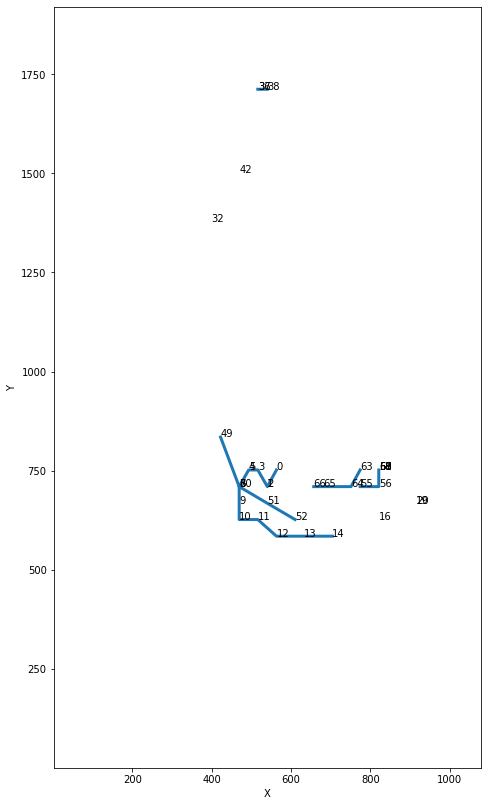

In [13]:
df_x = []
df_y = []

for points in df.loc[:, 7]:
    if points != None:
        x, y = points
        y = frame_height - y
    else:
        x = None
        y = None
    df_x.append(x)
    df_y.append(y)

plt.figure(figsize=(14,14))

plt.plot(df_x, df_y, linewidth=3)
plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df)):
    if df_x[i]!=None:
        plt.text(x=df_x[i], y=df_y[i], s=str(i))

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

plt.xlabel("X")
plt.ylabel("Y")

Text(0, 0.5, 'Y')

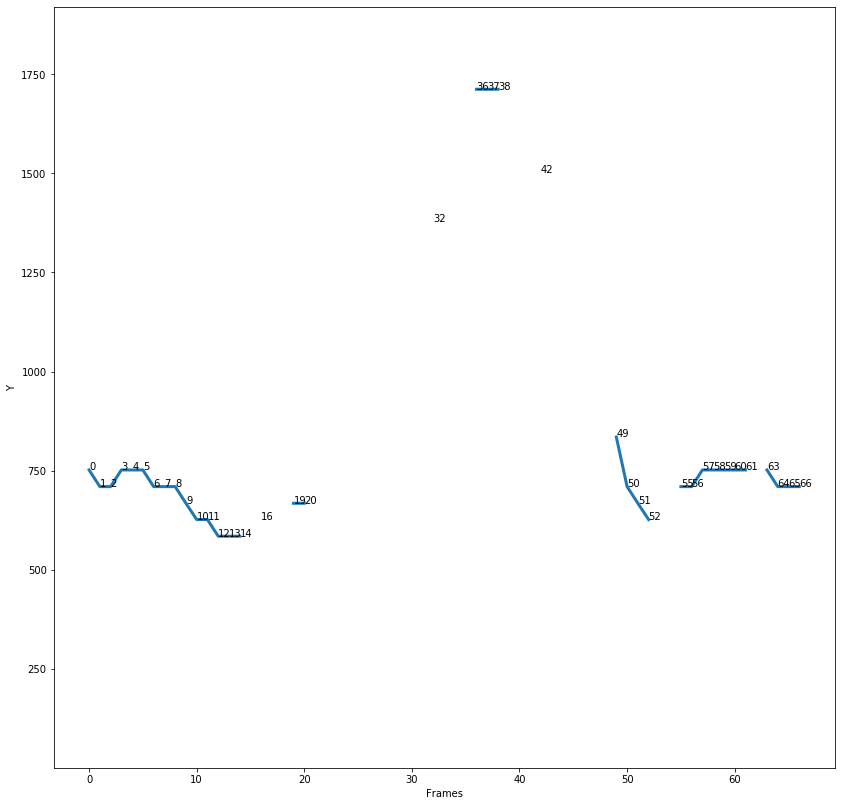

In [14]:
plt.figure(figsize=(14,14))

plt.plot(range(frame_counter-1), df_y, linewidth=3)
# plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df)):
    if df_x[i]!=None:
        plt.text(x=i, y=df_y[i], s=str(i))

# plt.gca().set_aspect('equal', adjustable='box')
# plt.draw()

plt.xlabel("Frames")
plt.ylabel("Y")

## Data Imputation

In [15]:
orient = "left"

In [16]:
vjump_points = [0, 1, 8]

if orient == "left":
    vjump_points.extend([5, 6, 7, 12, 13, 14])
elif orient == "right":
    vjump_points.extend([2, 3, 4, 9, 10, 11])

sorted(vjump_points)

[0, 1, 5, 6, 7, 8, 12, 13, 14]

In [17]:
df_imputed = df[vjump_points].copy()
df_imputed.head(40)

,0,1,8,5,6,7,12,13,14
1,"(516, 709)","(610, 793)","(633, 1168)","(610, 793)","(610, 1001)","(563, 1168)","(657, 1168)","(633, 1460)","(657, 1711)"
2,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
3,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
4,"(493, 709)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(516, 1168)","(680, 1168)","(610, 1377)","(633, 1711)"
5,"(493, 709)","(586, 793)","(657, 1126)","(610, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(586, 1377)","(633, 1711)"
6,"(493, 709)","(586, 834)","(657, 1126)","(586, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(563, 1377)","(633, 1711)"
7,"(493, 709)","(563, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)","(563, 1419)","(633, 1711)"
8,"(493, 751)","(586, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
9,"(469, 751)","(586, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
10,"(469, 751)","(563, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1252)","(704, 1168)","(516, 1419)","(633, 1753)"


In [18]:
def find_break_in_series(points_series, start_i):
    
    break_start_i = start_i - 1
    break_end_i = start_i
    break_found = False
    continue_crawling = True
    
    while (continue_crawling == True) and (break_end_i < points_series.index[-1]):
    
        if points_series[break_end_i] != None:
            break_found = False
            break_start_i = break_end_i
            break_end_i += 1
            
        else:
            break_found = True
            # break_end_i += 1
            
            while (break_found == True) and (break_end_i <= points_series.index[-1]):
                
                if points_series[break_end_i] == None:
                    break_end_i += 1
                else:
                    break_found = False
                    
            continue_crawling = False
        
    return break_start_i, break_end_i

def impute_break_in_series(points_series, start_i, end_i):
    
    diff = end_i - start_i
    start_x, start_y = points_series[start_i]
    end_x, end_y = points_series[end_i]
    
    diff_x = (end_x - start_x) / diff
    diff_y = (end_y - start_y) / diff
    
    multiplier = 1
    
    for i in range(start_i+1, end_i):
        x = int(round(start_x + (diff_x * multiplier)))
        y = int(round(start_y + (diff_y * multiplier)))
        points_series[i] = (x, y)
        multiplier += 1

def imputing_missing_points(points_series):
    
    series_start_i = points_series.index[0]
    series_end_i = points_series.index[-1]
    
    current_i = series_start_i
    
    while current_i < series_end_i:
        
        if points_series[current_i] == None:
            current_i += 1
            
        else:
            break_start_i, break_end_i = find_break_in_series(points_series, current_i)
            
            if break_end_i - break_start_i == 1:
                break
            elif break_end_i > series_end_i:
                break
            else: 
                impute_break_in_series(points_series, break_start_i, break_end_i)
                current_i = break_end_i
    
    return points_series

In [19]:
print("Continuing analysis - data imputation...\n")

for i in vjump_points:
    df_imputed[i] = imputing_missing_points(df_imputed[i])

Continuing analysis - data imputation...



In [20]:
df_imputed.head(40)

,0,1,8,5,6,7,12,13,14
1,"(516, 709)","(610, 793)","(633, 1168)","(610, 793)","(610, 1001)","(563, 1168)","(657, 1168)","(633, 1460)","(657, 1711)"
2,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
3,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
4,"(493, 709)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(516, 1168)","(680, 1168)","(610, 1377)","(633, 1711)"
5,"(493, 709)","(586, 793)","(657, 1126)","(610, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(586, 1377)","(633, 1711)"
6,"(493, 709)","(586, 834)","(657, 1126)","(586, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(563, 1377)","(633, 1711)"
7,"(493, 709)","(563, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)","(563, 1419)","(633, 1711)"
8,"(493, 751)","(586, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
9,"(469, 751)","(586, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
10,"(469, 751)","(563, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1252)","(704, 1168)","(516, 1419)","(633, 1753)"


Text(266.26925221469514, 0.5, 'Y')

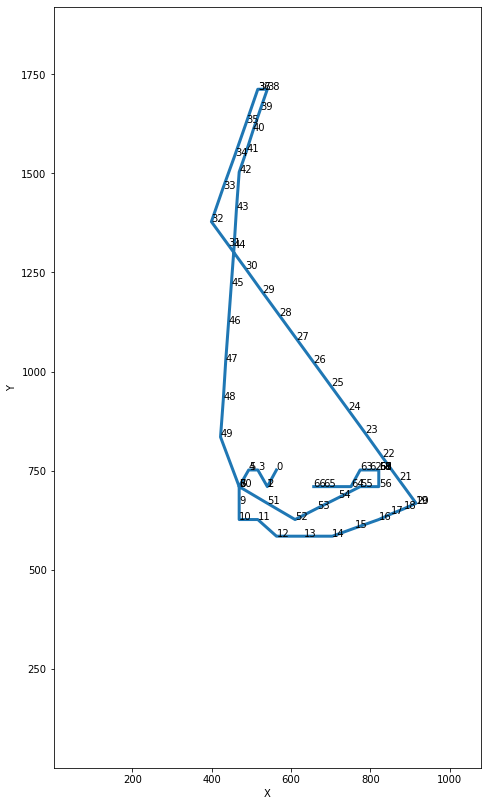

In [21]:
df_x = []
df_y = []

for points in df_imputed.loc[:, 7]:
    if points != None:
        x, y = points
        y = frame_height - y
    else:
        x = None
        y = None
    df_x.append(x)
    df_y.append(y)

plt.figure(figsize=(14,14))

plt.plot(df_x, df_y, linewidth=3)
plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df_imputed)):
    if df_x[i]!=None:
        plt.text(x=df_x[i], y=df_y[i], s=str(i))

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

plt.xlabel("X")
plt.ylabel("Y")

Text(0, 0.5, 'Y')

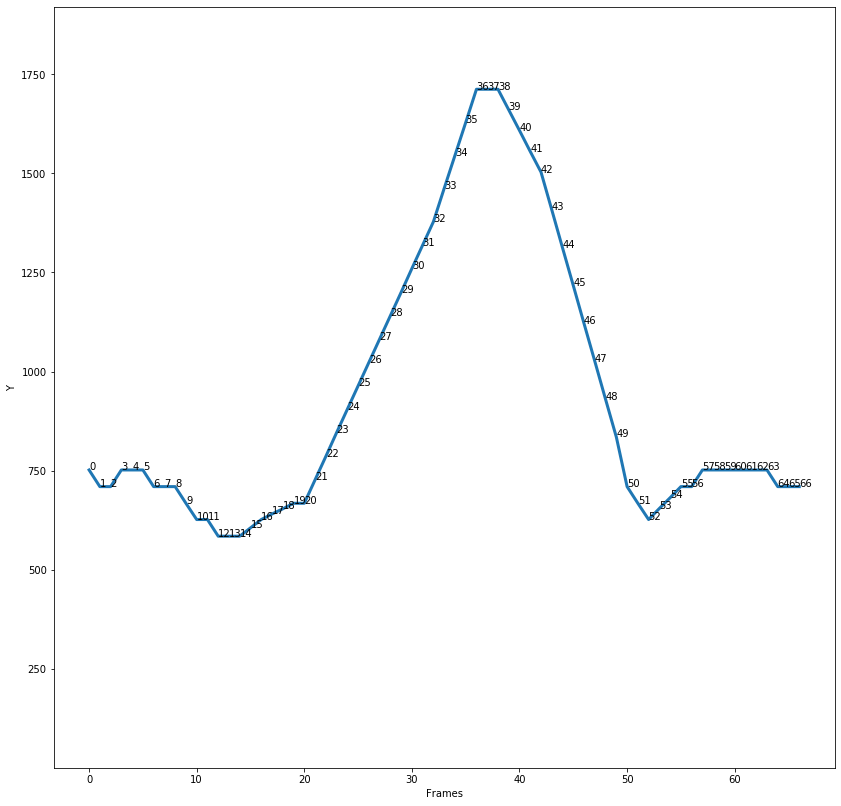

In [22]:
plt.figure(figsize=(14,14))

plt.plot(range(frame_counter-1), df_y, linewidth=3)
# plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df_imputed)):
    if df_x[i]!=None:
        plt.text(x=i, y=df_y[i], s=str(i))

plt.xlabel("Frames")
plt.ylabel("Y")

In [23]:
def overlay_imputed_skeleton(frame, points_row_imputed, points_row_original, frame_counter):

    frame_copy = np.copy(frame)

    for i in points_row_imputed.index:
        
        if points_row_imputed[i] != None:
            
            if points_row_original[i] != None:
        
                cv2.circle(frame_copy, points_row_imputed[i], 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            
            else:
                
                cv2.circle(frame_copy, points_row_imputed[i], 5, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
                
        cv2.putText(frame_copy, f"frame = {frame_counter}", (10, frame_height-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
                
    return frame_copy

In [24]:
# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_AGE.mp4"

def new_imputed_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_WITH_IMPUTED_BODY_POINTS"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

In [25]:
%%time

# Reading the video from filepath provided above and passing it through the age clasification method defined above.
# Source 1: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
# Source 2: https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

# Getting the video frame width and height.
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))

# Defining the codec and creating a VideoWriter object to save the output video at the same location.
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_imputed_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (frame_width, frame_height))

# Defining a new dataframe to store the skeleton point coordinates from each frame of the video.
frame_counter = 1

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        # Running human skeleton points detection on the grabbed frame.
        skeleton_frame = overlay_imputed_skeleton(frame, df_imputed.loc[frame_counter], df.loc[frame_counter], frame_counter)
        
        # Saving frame to output video using the VideoWriter object defined above.
        out.write(skeleton_frame)
        
        # Displaying the frame with age detected.
        cv2.imshow("Output Video", skeleton_frame)
        
        # Saving frame output skeleton point coordinates as a new row in above defined dataframe.
        # video_points_df[frame_counter] = skeleton_frame_points
        frame_counter += 1
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Releasing the VideoCapture and VideoWriter objects, and closing the displayed frame.
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Saved to {new_my_video}")

Saved to ../inputs_outputs/videos\vertical_jump_side_trial_1_WITH_IMPUTED_BODY_POINTS.mp4
Wall time: 4.51 s


## Data Points Normalization

In [26]:
df_imputed_norm = df_imputed.copy()

In [27]:
df_imputed_norm.head(40)

,0,1,8,5,6,7,12,13,14
1,"(516, 709)","(610, 793)","(633, 1168)","(610, 793)","(610, 1001)","(563, 1168)","(657, 1168)","(633, 1460)","(657, 1711)"
2,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
3,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
4,"(493, 709)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(516, 1168)","(680, 1168)","(610, 1377)","(633, 1711)"
5,"(493, 709)","(586, 793)","(657, 1126)","(610, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(586, 1377)","(633, 1711)"
6,"(493, 709)","(586, 834)","(657, 1126)","(586, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(563, 1377)","(633, 1711)"
7,"(493, 709)","(563, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)","(563, 1419)","(633, 1711)"
8,"(493, 751)","(586, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
9,"(469, 751)","(586, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
10,"(469, 751)","(563, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1252)","(704, 1168)","(516, 1419)","(633, 1753)"


In [28]:
origin_point = 0

In [29]:
def find_max_body_dimensions():
    
    max_body_dim_x = 0
    max_body_dim_y = 0
    
    for i in df.index:
        
        if df.loc[i, origin_point] != None:
        
            origin_x, origin_y = df.loc[i, origin_point]

            for p in [point for point in vjump_points if point != origin_point]:

                if df.loc[i, p] != None:

                    p_x, p_y = df.loc[i, p]

                    diff_x = abs(p_x - origin_x)
                    diff_y = abs(p_y - origin_y)

                    if diff_x > max_body_dim_x:
                        max_body_dim_x = diff_x
                    if diff_y > max_body_dim_y:
                        max_body_dim_y = diff_y
    
    return max_body_dim_x, max_body_dim_y

def find_upper_body_length():
    
    upper_body_length = 0
    
    for i in df.index:
        
        if ((df.loc[i, 1] != None) and (df.loc[i, 8] != None)):
            
            upper_chest_x, upper_chest_y = df.loc[i, 1]
            navel_x, navel_y = df.loc[i, 8]
            
            upper_body_length = int(round(np.sqrt((upper_chest_x - navel_x)**2 + (upper_chest_y - navel_y)**2)))
            
            break
            
    # print(upper_body_length)
    return upper_body_length

In [30]:
def normalizing_body_points(row):
    
    # max_body_dim_x, max_body_dim_y = find_max_body_dimensions()
    upper_body_length = find_upper_body_length()
    
    if row[origin_point] == None:
        return row
    
    origin_x, origin_y = row[origin_point]
    
    for i in row.index:
        
        if i == origin_point:
            norm_x = 0.0
            norm_y = 0.0
            row[i] = (norm_x, norm_y)
            
        elif row[i] == None:
            pass
        
        else:
            i_x, i_y = row[i]
            norm_x = (i_x - origin_x) / (upper_body_length * 3)
            norm_y = (i_y - origin_y) / (upper_body_length * 3)
            norm_y = -1 * norm_y
            row[i] = (norm_x, norm_y)
    
    return row

In [31]:
print("Continuing analysis - data normalization...\n")

for i in df_imputed_norm.index:
    df_imputed_norm.loc[i] = normalizing_body_points(df_imputed_norm.loc[i])

Continuing analysis - data normalization...



In [32]:
df_imputed_norm.head(40)

,0,1,8,5,6,7,12,13,14
1,"(0.0, 0.0)","(0.08333333333333333, -0.07446808510638298)","(0.10372340425531915, -0.40691489361702127)","(0.08333333333333333, -0.07446808510638298)","(0.08333333333333333, -0.25886524822695034)","(0.041666666666666664, -0.40691489361702127)","(0.125, -0.40691489361702127)","(0.10372340425531915, -0.6657801418439716)","(0.125, -0.8882978723404256)"
2,"(0.0, 0.0)","(0.08333333333333333, -0.11170212765957446)","(0.125, -0.4441489361702128)","(0.08333333333333333, -0.11170212765957446)","(0.06205673758865248, -0.29609929078014185)","(0.02127659574468085, -0.48138297872340424)","(0.125, -0.4441489361702128)","(0.10372340425531915, -0.6666666666666666)","(0.10372340425531915, -0.925531914893617)"
3,"(0.0, 0.0)","(0.08333333333333333, -0.11170212765957446)","(0.125, -0.4441489361702128)","(0.08333333333333333, -0.11170212765957446)","(0.06205673758865248, -0.29609929078014185)","(0.02127659574468085, -0.48138297872340424)","(0.125, -0.4441489361702128)","(0.10372340425531915, -0.6666666666666666)","(0.10372340425531915, -0.925531914893617)"
4,"(0.0, 0.0)","(0.10372340425531915, -0.07446808510638298)","(0.1453900709219858, -0.40691489361702127)","(0.10372340425531915, -0.07446808510638298)","(0.08244680851063829, -0.25886524822695034)","(0.020390070921985817, -0.40691489361702127)","(0.16578014184397163, -0.40691489361702127)","(0.10372340425531915, -0.5921985815602837)","(0.12411347517730496, -0.8882978723404256)"
5,"(0.0, 0.0)","(0.08244680851063829, -0.07446808510638298)","(0.1453900709219858, -0.3696808510638298)","(0.10372340425531915, -0.07446808510638298)","(0.06205673758865248, -0.25886524822695034)","(0.0, -0.40691489361702127)","(0.16578014184397163, -0.3696808510638298)","(0.08244680851063829, -0.5921985815602837)","(0.12411347517730496, -0.8882978723404256)"
6,"(0.0, 0.0)","(0.08244680851063829, -0.11081560283687943)","(0.1453900709219858, -0.3696808510638298)","(0.08244680851063829, -0.07446808510638298)","(0.06205673758865248, -0.25886524822695034)","(0.0, -0.40691489361702127)","(0.16578014184397163, -0.3696808510638298)","(0.06205673758865248, -0.5921985815602837)","(0.12411347517730496, -0.8882978723404256)"
7,"(0.0, 0.0)","(0.06205673758865248, -0.11081560283687943)","(0.16578014184397163, -0.40691489361702127)","(0.08244680851063829, -0.11081560283687943)","(0.06205673758865248, -0.29609929078014185)","(-0.02127659574468085, -0.4441489361702128)","(0.16578014184397163, -0.40691489361702127)","(0.06205673758865248, -0.6294326241134752)","(0.12411347517730496, -0.8882978723404256)"
8,"(0.0, 0.0)","(0.08244680851063829, -0.07358156028368794)","(0.16578014184397163, -0.3696808510638298)","(0.08244680851063829, -0.07358156028368794)","(0.06205673758865248, -0.25886524822695034)","(-0.02127659574468085, -0.40691489361702127)","(0.1870567375886525, -0.3696808510638298)","(0.041666666666666664, -0.5921985815602837)","(0.12411347517730496, -0.851063829787234)"
9,"(0.0, 0.0)","(0.10372340425531915, -0.11081560283687943)","(0.1870567375886525, -0.3696808510638298)","(0.10372340425531915, -0.11081560283687943)","(0.06294326241134751, -0.29609929078014185)","(0.0, -0.40691489361702127)","(0.20833333333333334, -0.3696808510638298)","(0.06294326241134751, -0.5921985815602837)","(0.1453900709219858, -0.851063829787234)"
10,"(0.0, 0.0)","(0.08333333333333333, -0.11081560283687943)","(0.1870567375886525, -0.3696808510638298)","(0.10372340425531915, -0.11081560283687943)","(0.06294326241134751, -0.29609929078014185)","(0.0, -0.4441489361702128)","(0.20833333333333334, -0.3696808510638298)","(0.041666666666666664, -0.5921985815602837)","(0.1453900709219858, -0.8882978723404256)"


In [33]:
df_imputed_norm.tail(40)

,0,1,8,5,6,7,12,13,14
28,"(0.0, 0.0)","(0.06294326241134751, -0.14804964539007093)","(0.16666666666666666, -0.40691489361702127)","(0.08333333333333333, -0.14804964539007093)","(-0.041666666666666664, -0.25886524822695034)","(0.12854609929078015, -0.0398936170212766)","(0.1870567375886525, -0.40691489361702127)","(0.0, -0.5913120567375887)","(0.1453900709219858, -0.8138297872340425)"
29,"(0.0, 0.0)","(0.06294326241134751, -0.14804964539007093)","(0.16666666666666666, -0.40691489361702127)","(0.08333333333333333, -0.14804964539007093)","(-0.041666666666666664, -0.18528368794326242)","(0.09042553191489362, -0.024822695035460994)","(0.1870567375886525, -0.40691489361702127)","(0.02127659574468085, -0.5921985815602837)","(0.1453900709219858, -0.851063829787234)"
30,"(0.0, 0.0)","(0.08333333333333333, -0.11081560283687943)","(0.16666666666666666, -0.40691489361702127)","(0.08333333333333333, -0.11081560283687943)","(-0.041666666666666664, -0.11081560283687943)","(0.05230496453900709, -0.00975177304964539)","(0.1870567375886525, -0.40691489361702127)","(0.041666666666666664, -0.6294326241134752)","(0.1453900709219858, -0.8882978723404256)"
31,"(0.0, 0.0)","(0.06294326241134751, -0.11170212765957446)","(0.16666666666666666, -0.40691489361702127)","(0.08333333333333333, -0.11170212765957446)","(-0.06205673758865248, -0.07446808510638298)","(0.014184397163120567, 0.0062056737588652485)","(0.1870567375886525, -0.40691489361702127)","(0.06294326241134751, -0.6294326241134752)","(0.1453900709219858, -0.925531914893617)"
32,"(0.0, 0.0)","(0.06294326241134751, -0.11081560283687943)","(0.125, -0.40691489361702127)","(0.08333333333333333, -0.07358156028368794)","(-0.020390070921985817, -0.07358156028368794)","(-0.023936170212765957, 0.022163120567375887)","(0.16666666666666666, -0.40691489361702127)","(0.10372340425531915, -0.6657801418439716)","(0.125, -0.9618794326241135)"
33,"(0.0, 0.0)","(0.041666666666666664, -0.11081560283687943)","(0.125, -0.40691489361702127)","(0.10372340425531915, -0.07358156028368794)","(-0.015070921985815602, -0.03723404255319149)","(-0.06205673758865248, 0.03723404255319149)","(0.16666666666666666, -0.40691489361702127)","(0.1453900709219858, -0.6657801418439716)","(0.125, -0.924645390070922)"
34,"(0.0, 0.0)","(0.0726950354609929, -0.09219858156028368)","(0.1347517730496454, -0.3882978723404255)","(0.11347517730496454, -0.09219858156028368)","(0.0, 0.018617021276595744)","(-0.026595744680851064, 0.09308510638297872)","(0.1551418439716312, -0.3882978723404255)","(0.1551418439716312, -0.6471631205673759)","(0.1347517730496454, -0.9069148936170213)"
35,"(0.0, 0.0)","(0.06205673758865248, -0.07446808510638298)","(0.1453900709219858, -0.37056737588652483)","(0.10372340425531915, -0.07446808510638298)","(0.015070921985815602, 0.07446808510638298)","(0.010638297872340425, 0.14804964539007093)","(0.16578014184397163, -0.37056737588652483)","(0.1453900709219858, -0.6294326241134752)","(0.16578014184397163, -0.925531914893617)"
36,"(0.0, 0.0)","(0.06205673758865248, -0.11170212765957446)","(0.1453900709219858, -0.3891843971631206)","(0.08333333333333333, -0.07446808510638298)","(0.020390070921985817, 0.11081560283687943)","(0.03634751773049645, 0.18439716312056736)","(0.1870567375886525, -0.37056737588652483)","(0.12411347517730496, -0.6294326241134752)","(0.1870567375886525, -0.925531914893617)"
37,"(0.0, 0.0)","(0.08333333333333333, -0.07446808510638298)","(0.16666666666666666, -0.37056737588652483)","(0.10460992907801418, -0.03723404255319149)","(0.041666666666666664, 0.14804964539007093)","(0.08333333333333333, 0.25886524822695034)","(0.20833333333333334, -0.37056737588652483)","(0.1453900709219858, -0.6294326241134752)","(0.20833333333333334, -0.925531914893617)"


Text(94.45500000000001, 0.5, 'Y')

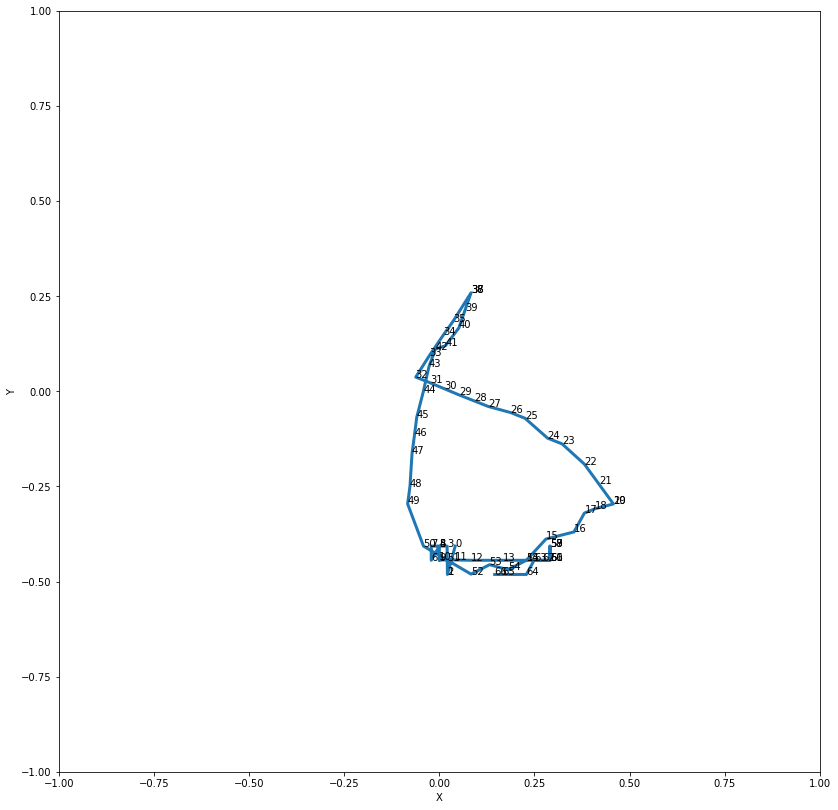

In [34]:
df_x = []
df_y = []

for points in df_imputed_norm.loc[:, 7]:
    if points != None:
        x, y = points
        # y = frame_height - y
    else:
        x = None
        y = None
    df_x.append(x)
    df_y.append(y)

plt.figure(figsize=(14,14))

plt.plot(df_x, df_y, linewidth=3)
plt.xlim([-1, 1])
plt.ylim([-1, 1])

for i in range(len(df_imputed_norm)):
    if df_x[i]!=None:
        plt.text(x=df_x[i], y=df_y[i], s=str(i))

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

plt.xlabel("X")
plt.ylabel("Y")

Text(0, 0.5, 'Y')

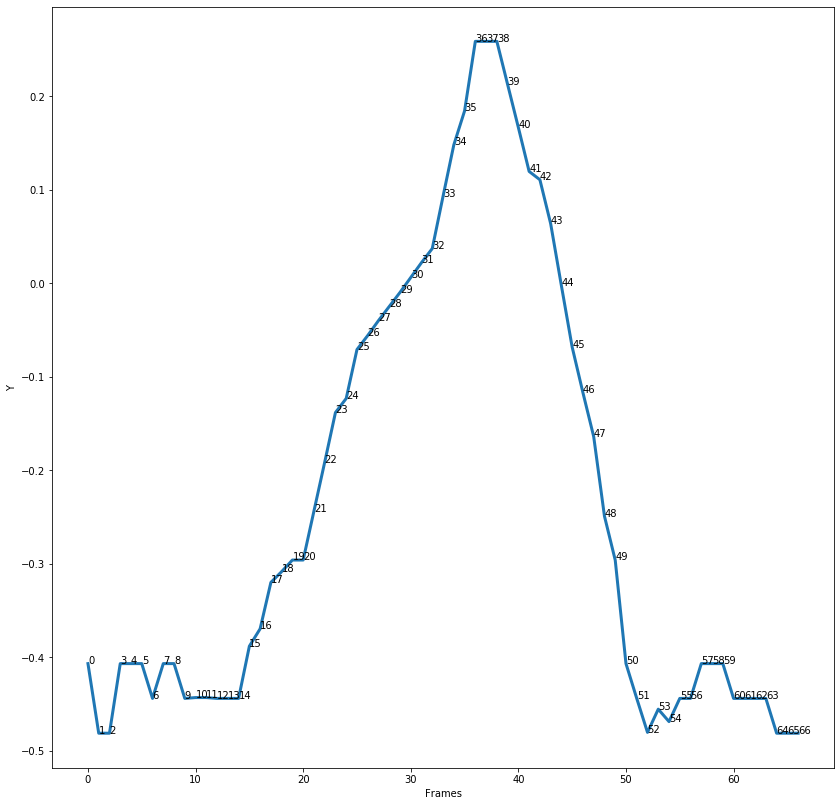

In [35]:
plt.figure(figsize=(14,14))

plt.plot(range(frame_counter-1), df_y, linewidth=3)
# plt.xlim([-0.5, 0.5])
# plt.ylim([-0.5, 0.5])

for i in range(len(df_imputed_norm)):
    if df_x[i]!=None:
        plt.text(x=i, y=df_y[i], s=str(i))

# plt.gca().set_aspect('equal', adjustable='box')
# plt.draw()

plt.xlabel("Frames")
plt.ylabel("Y")

In [36]:
def normalized_skeleton(points_row_norm, points_row_original, frame_counter):

    frame = cv2.imread("../inputs_outputs/white_frame.jpg")

    for i in points_row_norm.index:
        
        if points_row_norm[i] != None:
            
            x_norm, y_norm = points_row_norm[i]
            x_norm_sc = int(round(x_norm * 1000 + 1000))
            y_norm_sc = int(round(y_norm * 1000 + 1000))
            
            if points_row_original[i] != None:
        
                cv2.circle(frame, (x_norm_sc, y_norm_sc), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frame, f"{i}", (x_norm_sc, y_norm_sc), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            
            else:
                
                cv2.circle(frame, (x_norm_sc, y_norm_sc), 5, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frame, f"{i}", (x_norm_sc, y_norm_sc), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            
        cv2.putText(frame, f"frame = {frame_counter}", (10, 1990), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
                
    return frame

In [37]:
# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_AGE.mp4"

def new_normalized_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_WITH_NORMALIZED_BODY_POINTS"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

In [38]:
%%time

# Reading the video from filepath provided above and passing it through the age clasification method defined above.
# Source 1: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
# Source 2: https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

# Getting the video frame width and height.
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))

# Defining the codec and creating a VideoWriter object to save the output video at the same location.
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_normalized_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (2000, 2000))

# Defining a new dataframe to store the skeleton point coordinates from each frame of the video.
frame_counter = 1

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        # Running human skeleton points detection on the grabbed frame.
        skeleton_frame = normalized_skeleton(df_imputed_norm.loc[frame_counter], df.loc[frame_counter], frame_counter)
        
        # Saving frame to output video using the VideoWriter object defined above.
        out.write(skeleton_frame)
        
        # Displaying the frame with age detected.
        cv2.imshow("Output Video", skeleton_frame)
        
        # Saving frame output skeleton point coordinates as a new row in above defined dataframe.
        # video_points_df[frame_counter] = skeleton_frame_points
        frame_counter += 1
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Releasing the VideoCapture and VideoWriter objects, and closing the displayed frame.
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Saved to {new_my_video}")

Saved to ../inputs_outputs/videos\vertical_jump_side_trial_1_WITH_NORMALIZED_BODY_POINTS.mp4
Wall time: 9.71 s


## Setting Rules for Grading Vertical Jump

In [39]:
df_imputed.head(40)

,0,1,8,5,6,7,12,13,14
1,"(516, 709)","(610, 793)","(633, 1168)","(610, 793)","(610, 1001)","(563, 1168)","(657, 1168)","(633, 1460)","(657, 1711)"
2,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
3,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
4,"(493, 709)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(516, 1168)","(680, 1168)","(610, 1377)","(633, 1711)"
5,"(493, 709)","(586, 793)","(657, 1126)","(610, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(586, 1377)","(633, 1711)"
6,"(493, 709)","(586, 834)","(657, 1126)","(586, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(563, 1377)","(633, 1711)"
7,"(493, 709)","(563, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)","(563, 1419)","(633, 1711)"
8,"(493, 751)","(586, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
9,"(469, 751)","(586, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
10,"(469, 751)","(563, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1252)","(704, 1168)","(516, 1419)","(633, 1753)"


Text(266.26925221469514, 0.5, 'Y')

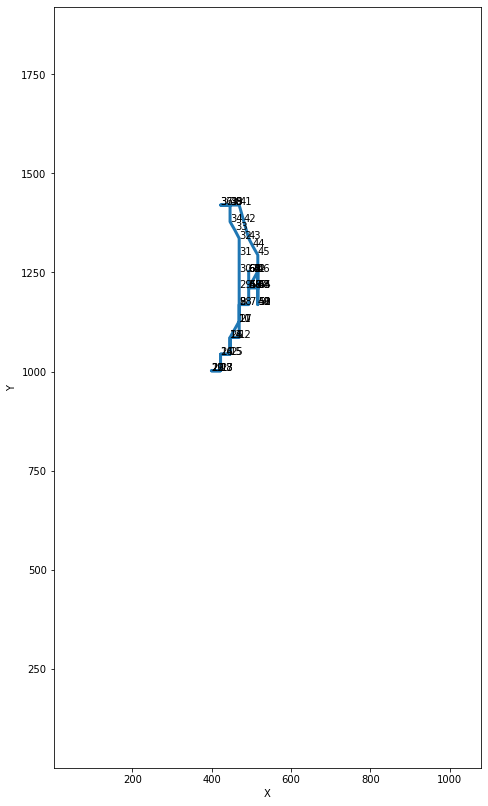

In [40]:
df_x = []
df_y = []

for points in df_imputed.loc[:, 0]:
    if points != None:
        x, y = points
        y = frame_height - y
    else:
        x = None
        y = None
    df_x.append(x)
    df_y.append(y)

plt.figure(figsize=(14,14))

plt.plot(df_x, df_y, linewidth=3)
plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df_imputed)):
    if df_x[i]!=None:
        plt.text(x=df_x[i], y=df_y[i], s=str(i))

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

plt.xlabel("X")
plt.ylabel("Y")

Text(0, 0.5, 'Y')

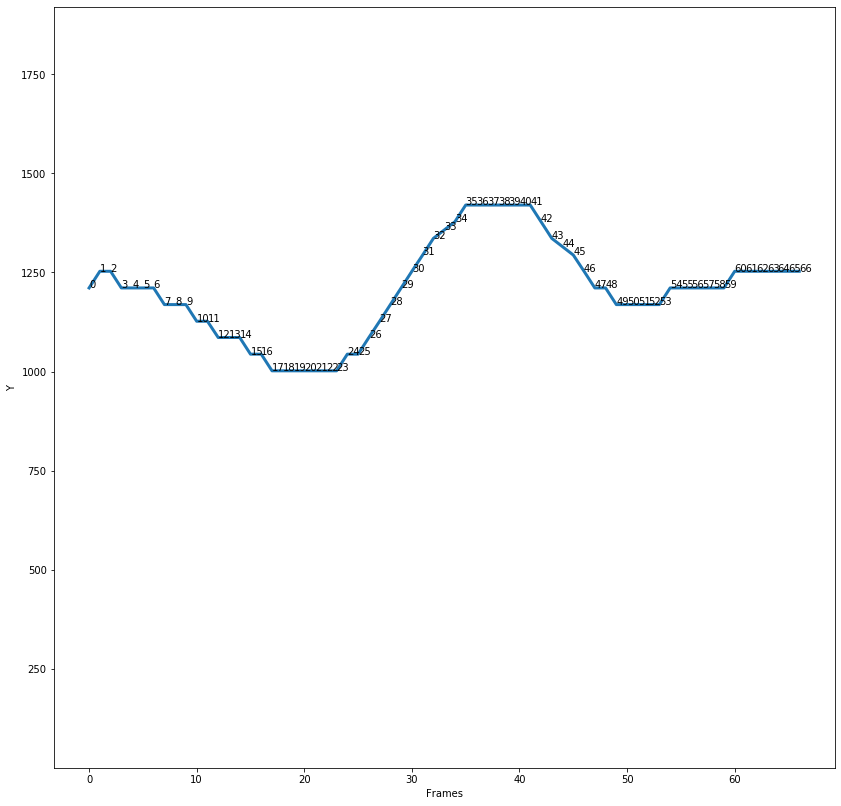

In [41]:
plt.figure(figsize=(14,14))

plt.plot(range(frame_counter-1), df_y, linewidth=3)
# plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df_imputed)):
    if df_x[i]!=None:
        plt.text(x=i, y=df_y[i], s=str(i))

plt.xlabel("Frames")
plt.ylabel("Y")

In [42]:
# Tracking body point 0 in Y-axis to get frame number of peak in vertical jump.

print("Continuing analysis - identifying critical frames...\n")

forehead_y_movement = [frame_height - x[1] for x in df_imputed[0]]

Continuing analysis - identifying critical frames...



In [43]:
jump_peak_indexes = []

for i, y in enumerate(forehead_y_movement):
    if y == max(forehead_y_movement):
        jump_peak_indexes.append(i+1)

In [44]:
jump_peak_frame = int(np.median(jump_peak_indexes))
jump_peak_frame

39

In [45]:
jump_squat_indexes = []

for i, y in enumerate(forehead_y_movement[:jump_peak_frame]):
    if y == min(forehead_y_movement[:jump_peak_frame]):
        jump_squat_indexes.append(i+1)

In [46]:
jump_squat_frame = int(np.median(jump_squat_indexes))
jump_squat_frame

21

In [47]:
jump_land_indexes = []

for i, y in enumerate(forehead_y_movement[jump_peak_frame:]):
    if y == min(forehead_y_movement[jump_peak_frame:]):
        jump_land_indexes.append(i+1+jump_peak_frame)

In [48]:
jump_land_frame = int(np.median(jump_land_indexes))
jump_land_frame

52

In [49]:
# Defining a function to return the image filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_image.jpg", OUTPUT filepath will be "my_folder1/my_folder2/my_image_WITH_AGE.jpg"

def new_frame_name(org_vid_path, frame_counter):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_frame_name_ext = ""
    if frame_counter == jump_squat_frame:
        new_frame_name_ext = vid_name+"_1_JUMP_SQUAT"+".png"
    elif frame_counter == jump_peak_frame:
        new_frame_name_ext = vid_name+"_2_JUMP_PEAK"+".png"
    elif frame_counter == jump_land_frame:
        new_frame_name_ext = vid_name+"_3_JUMP_LAND"+".png"
        
    new_frame_path = os.path.join(vid_path, new_frame_name_ext)

    return new_frame_path

In [50]:
def calculate_angle_between_three_points(point_1, point_2, point_3):
    
    x_1, y_1 = point_1
    x_2, y_2 = point_2
    x_3, y_3 = point_3
    
    side_1_2 = np.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2)
    side_2_3 = np.sqrt((x_3 - x_2)**2 + (y_3 - y_2)**2)
    side_3_1 = np.sqrt((x_1 - x_3)**2 + (y_1 - y_3)**2)
    
    cos_theta_rad = ((side_1_2**2 + side_2_3**2 - side_3_1**2) / (2 * side_1_2 * side_2_3))
    
    theta_rad = np.arccos(cos_theta_rad)
    
    theta_deg = np.rad2deg(theta_rad)
    
    return theta_deg

In [51]:
def jump_quality_at_squat_frame(frame, points_row_original, points_row_imputed, points_row_norm):
    
    frame_copy = np.copy(frame)
    
    temp_arm_points = []
    temp_leg_points = []
    temp_torso_points = []
    
    if orient == "left":
        temp_arm_points = [5, 6, 7]
        temp_leg_points = [12, 13, 14]
        temp_torso_points = [5, 12]
    elif orient == "right":
        temp_arm_points = [2, 3, 4]
        temp_leg_points = [9, 10, 11]
        temp_torso_points = [2, 9]
        
    elbow_angle = calculate_angle_between_three_points(points_row_norm[temp_arm_points[0]],
                                                       points_row_norm[temp_arm_points[1]],
                                                       points_row_norm[temp_arm_points[2]]
                                                      )
    
    knee_angle = calculate_angle_between_three_points(points_row_norm[temp_leg_points[0]],
                                                      points_row_norm[temp_leg_points[1]],
                                                      points_row_norm[temp_leg_points[2]]
                                                     )
    
    shoulder_angle = calculate_angle_between_three_points(points_row_norm[temp_arm_points[1]],
                                                          points_row_norm[temp_arm_points[0]],
                                                          points_row_norm[temp_torso_points[1]]
                                                         )
    
    hip_angle = calculate_angle_between_three_points(points_row_norm[temp_torso_points[0]],
                                                     points_row_norm[temp_torso_points[1]],
                                                     points_row_norm[temp_leg_points[1]]
                                                    )
    
    for i, p in enumerate(temp_arm_points[:-1]):
        if elbow_angle > 160:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_arm_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_arm_points[i+1]], (0, 0, 255), thickness=2)
    
    for i, p in enumerate(temp_leg_points[:-1]):
        if 75 < knee_angle < 105:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 0, 255), thickness=2)
            
    for i in points_row_imputed.index:
        if points_row_imputed[i] != None:
            if points_row_original[i] != None:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            else:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.putText(frame_copy, f"frame = {frame_counter}", (10, frame_height-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
    
    print(f"Elbow angle = {elbow_angle}")
    print(f"Knee angle = {knee_angle}")
    print(f"Shoulder angle = {shoulder_angle}")
    print(f"Hip angle = {hip_angle}")
    
    return frame_copy

In [52]:
def jump_quality_at_peak_frame(frame, points_row_original, points_row_imputed, points_row_norm):
    
    frame_copy = np.copy(frame)
    
    temp_arm_points = []
    temp_leg_points = []
    temp_torso_points = []
    
    if orient == "left":
        temp_arm_points = [5, 6, 7]
        temp_leg_points = [12, 13, 14]
        temp_torso_points = [5, 12]
    elif orient == "right":
        temp_arm_points = [2, 3, 4]
        temp_leg_points = [9, 10, 11]
        temp_torso_points = [2, 9]
        
    elbow_angle = calculate_angle_between_three_points(points_row_norm[temp_arm_points[0]],
                                                       points_row_norm[temp_arm_points[1]],
                                                       points_row_norm[temp_arm_points[2]]
                                                      )
    
    knee_angle = calculate_angle_between_three_points(points_row_norm[temp_leg_points[0]],
                                                      points_row_norm[temp_leg_points[1]],
                                                      points_row_norm[temp_leg_points[2]]
                                                      )
    
    torso_angle = calculate_angle_between_three_points((points_row_norm[temp_torso_points[0]][0], points_row_norm[temp_torso_points[0]][1] - 1), 
                                                       points_row_norm[temp_torso_points[0]],
                                                       points_row_norm[temp_torso_points[1]]
                                                      )
    
    for i, p in enumerate(temp_arm_points[:-1]):
        if elbow_angle > 150:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_arm_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_arm_points[i+1]], (0, 0, 255), thickness=2)
    
    for i, p in enumerate(temp_leg_points[:-1]):
        if knee_angle > 150:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 0, 255), thickness=2)
            
    for i, p in enumerate(temp_torso_points[:-1]):
        if torso_angle < 20:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_torso_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_torso_points[i+1]], (0, 0, 255), thickness=2)
    
    for i in points_row_imputed.index:
        if points_row_imputed[i] != None:
            if points_row_original[i] != None:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            else:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.putText(frame_copy, f"frame = {frame_counter}", (10, frame_height-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
    
    print(f"Elbow angle = {elbow_angle}")
    print(f"Knee angle = {knee_angle}")
    print(f"Torso angle = {torso_angle}")
    
    return frame_copy

In [53]:
def jump_quality_at_land_frame(frame, points_row_original, points_row_imputed, points_row_norm):
    
    frame_copy = np.copy(frame)
    
    temp_arm_points = []
    temp_leg_points = []
    temp_torso_points = []
    
    if orient == "left":
        temp_arm_points = [5, 6, 7]
        temp_leg_points = [12, 13, 14]
        temp_torso_points = [5, 12]
    elif orient == "right":
        temp_arm_points = [2, 3, 4]
        temp_leg_points = [9, 10, 11]
        temp_torso_points = [2, 9]
    
    knee_angle = calculate_angle_between_three_points(points_row_norm[temp_leg_points[0]],
                                                      points_row_norm[temp_leg_points[1]],
                                                      points_row_norm[temp_leg_points[2]]
                                                     )
    
    torso_angle = calculate_angle_between_three_points((points_row_norm[temp_torso_points[0]][0], points_row_norm[temp_torso_points[0]][1] - 1), 
                                                       points_row_norm[temp_torso_points[0]],
                                                       points_row_norm[temp_torso_points[1]]
                                                      )
    
    for i, p in enumerate(temp_leg_points[:-1]):
        if knee_angle < 150:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 0, 255), thickness=2)
            
    for i, p in enumerate(temp_torso_points[:-1]):
        if torso_angle < 10:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_torso_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_torso_points[i+1]], (0, 0, 255), thickness=2)
    
    for i in points_row_imputed.index:
        if points_row_imputed[i] != None:
            if points_row_original[i] != None:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            else:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.putText(frame_copy, f"frame = {frame_counter}", (10, frame_height-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
    
    print(f"Knee angle = {knee_angle}")
    print(f"Torso angle = {torso_angle}")
    
    return frame_copy

In [54]:
def calculate_distance_from_squat_to_land():
    
    upper_body_length = find_upper_body_length()
    
    ankle_point = 0
    
    if orient == "left":
        ankle_point = 14
    elif orient == "right":
        ankle_point = 11
        
    squat_ankle_x, squat_ankle_y = df_imputed.loc[jump_squat_frame, ankle_point]
    land_ankle_x, land_ankle_y = df_imputed.loc[jump_land_frame, ankle_point]
    
    landing_distance = int(round(np.sqrt((land_ankle_x - squat_ankle_x)**2 + (land_ankle_y - squat_ankle_y)**2)))
    
    print(f"Landing distance = {round(landing_distance/upper_body_length, 2)} X Upper Body Length")

In [55]:
%%time

# Reading the video from filepath provided above and passing it through the age clasification method defined above.
# Source 1: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
# Source 2: https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

# Defining a new dataframe to store the skeleton point coordinates from each frame of the video.
frame_counter = 1

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        if frame_counter == jump_squat_frame:
            print(f"{jump_squat_frame}")
            skeleton_frame = jump_quality_at_squat_frame(frame, df.loc[frame_counter], df_imputed.loc[frame_counter], df_imputed_norm.loc[frame_counter])
            
            new_my_frame = new_frame_name(my_video, frame_counter)
            cv2.imwrite(new_my_frame, skeleton_frame)
            print(f"Saved to {new_my_frame}\n")
            
        elif frame_counter == jump_peak_frame:
            print(f"{jump_peak_frame}")
            skeleton_frame = jump_quality_at_peak_frame(frame, df.loc[frame_counter], df_imputed.loc[frame_counter], df_imputed_norm.loc[frame_counter])
            
            new_my_frame = new_frame_name(my_video, frame_counter)
            cv2.imwrite(new_my_frame, skeleton_frame)
            print(f"Saved to {new_my_frame}\n")
            
        elif frame_counter == jump_land_frame:
            print(f"{jump_land_frame}")
            skeleton_frame = jump_quality_at_land_frame(frame, df.loc[frame_counter], df_imputed.loc[frame_counter], df_imputed_norm.loc[frame_counter])
            
            new_my_frame = new_frame_name(my_video, frame_counter)
            cv2.imwrite(new_my_frame, skeleton_frame)
            print(f"Saved to {new_my_frame}\n")
            
            calculate_distance_from_squat_to_land()
        
        frame_counter += 1
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Releasing the VideoCapture object, and closing the displayed frame.
cap.release()
cv2.destroyAllWindows()
print("Done")

21
Elbow angle = 179.7652235873889
Knee angle = 85.27449875697648
Shoulder angle = 29.292198505393344
Hip angle = 82.72647797494938
Saved to ../inputs_outputs/videos\vertical_jump_side_trial_1_1_JUMP_SQUAT.png

39
Elbow angle = 140.87658720570866
Knee angle = 152.14445100625764
Torso angle = 14.036243467926457
Saved to ../inputs_outputs/videos\vertical_jump_side_trial_1_2_JUMP_PEAK.png

52
Knee angle = 122.16791017645693
Torso angle = 3.084812330497371
Saved to ../inputs_outputs/videos\vertical_jump_side_trial_1_3_JUMP_LAND.png

Landing distance = 0.11 X Upper Body Length
Done
Wall time: 1.66 s


## FINAL OUTPUT

In [70]:
def jump_quality_at_squat_frame(frame, points_row_original, points_row_imputed, points_row_norm):
    
    frame_copy = np.copy(frame)
    
    temp_arm_points = []
    temp_leg_points = []
    temp_torso_points = []
    
    if orient == "left":
        temp_arm_points = [5, 6, 7]
        temp_leg_points = [12, 13, 14]
        temp_torso_points = [5, 12]
    elif orient == "right":
        temp_arm_points = [2, 3, 4]
        temp_leg_points = [9, 10, 11]
        temp_torso_points = [2, 9]
        
    elbow_angle = calculate_angle_between_three_points(points_row_norm[temp_arm_points[0]],
                                                       points_row_norm[temp_arm_points[1]],
                                                       points_row_norm[temp_arm_points[2]]
                                                      )
    
    knee_angle = calculate_angle_between_three_points(points_row_norm[temp_leg_points[0]],
                                                      points_row_norm[temp_leg_points[1]],
                                                      points_row_norm[temp_leg_points[2]]
                                                     )
    
    shoulder_angle = calculate_angle_between_three_points(points_row_norm[temp_arm_points[1]],
                                                          points_row_norm[temp_arm_points[0]],
                                                          points_row_norm[temp_torso_points[1]]
                                                         )
    
    hip_angle = calculate_angle_between_three_points(points_row_norm[temp_torso_points[0]],
                                                     points_row_norm[temp_torso_points[1]],
                                                     points_row_norm[temp_leg_points[1]]
                                                    )
    
    correct_squat_posture = False
    elbow_angle_pass = False
    knee_angle_pass = False
    shoulder_angle_pass = False
    hip_angle_pass = False
    
    for i, p in enumerate(temp_arm_points[:-1]):
        if elbow_angle > 160:
            elbow_angle_pass = True
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_arm_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_arm_points[i+1]], (0, 0, 255), thickness=2)
    
    for i, p in enumerate(temp_leg_points[:-1]):
        if 75 < knee_angle < 105:
            knee_angle_pass = True
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 0, 255), thickness=2)
            
    for i in points_row_imputed.index:
        if points_row_imputed[i] != None:
            if points_row_original[i] != None:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            else:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.putText(frame_copy, f"frame = {frame_counter}", (10, frame_height-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
    
    
    if elbow_angle_pass and knee_angle_pass:
        correct_squat_posture = True
    
    frame_text = ""
    if correct_squat_posture:
        frame_text = "Squat posture : PASS"
    else:
        frame_text = "Squat posture : FAIL"
    
    report_text = f'''
    {frame_text} (frame {frame_counter} of {total_frames})
    Body angles:
    \tElbow:\t{round(elbow_angle, 2)} deg\t[correct range: >160 deg]
    \tKnee:\t{round(knee_angle, 2)} deg\t[correct range: 75-105 deg]
    \tShldr:\t{round(shoulder_angle, 2)} deg
    \tHip:\t{round(knee_angle, 2)} deg
    '''

    return frame_copy, frame_text, report_text

In [71]:
def jump_quality_at_peak_frame(frame, points_row_original, points_row_imputed, points_row_norm):
    
    frame_copy = np.copy(frame)
    
    temp_arm_points = []
    temp_leg_points = []
    temp_torso_points = []
    
    if orient == "left":
        temp_arm_points = [5, 6, 7]
        temp_leg_points = [12, 13, 14]
        temp_torso_points = [5, 12]
    elif orient == "right":
        temp_arm_points = [2, 3, 4]
        temp_leg_points = [9, 10, 11]
        temp_torso_points = [2, 9]
        
    elbow_angle = calculate_angle_between_three_points(points_row_norm[temp_arm_points[0]],
                                                       points_row_norm[temp_arm_points[1]],
                                                       points_row_norm[temp_arm_points[2]]
                                                      )
    
    knee_angle = calculate_angle_between_three_points(points_row_norm[temp_leg_points[0]],
                                                      points_row_norm[temp_leg_points[1]],
                                                      points_row_norm[temp_leg_points[2]]
                                                      )
    
    torso_angle = calculate_angle_between_three_points((points_row_norm[temp_torso_points[0]][0], points_row_norm[temp_torso_points[0]][1] - 1), 
                                                       points_row_norm[temp_torso_points[0]],
                                                       points_row_norm[temp_torso_points[1]]
                                                      )
    
    correct_peak_posture = False
    elbow_angle_pass = False
    knee_angle_pass = False
    torso_angle_pass = False
    
    for i, p in enumerate(temp_arm_points[:-1]):
        if elbow_angle > 150:
            elbow_angle_pass = True
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_arm_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_arm_points[i+1]], (0, 0, 255), thickness=2)
    
    for i, p in enumerate(temp_leg_points[:-1]):
        if knee_angle > 150:
            knee_angle_pass = True
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 0, 255), thickness=2)
            
    for i, p in enumerate(temp_torso_points[:-1]):
        if torso_angle < 20:
            torso_angle_pass = True
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_torso_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_torso_points[i+1]], (0, 0, 255), thickness=2)
    
    for i in points_row_imputed.index:
        if points_row_imputed[i] != None:
            if points_row_original[i] != None:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            else:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.putText(frame_copy, f"frame = {frame_counter}", (10, frame_height-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
    
    
    if elbow_angle_pass and knee_angle_pass and torso_angle_pass:
        correct_peak_posture = True
    
    frame_text = ""
    if correct_peak_posture:
        frame_text = "Jump Peak posture : PASS"
    else:
        frame_text = "Jump Peak posture : FAIL"
    
    report_text = f'''
    {frame_text} (frame {frame_counter} of {total_frames})
    Body angles:
    \tElbow:\t{round(elbow_angle, 2)} deg\t[correct range: >150 deg]
    \tKnee:\t{round(knee_angle, 2)} deg\t[correct range: >150 deg]
    \tTorso:\t{round(torso_angle, 2)} deg\t[correct range: <20 deg]
    '''

    return frame_copy, frame_text, report_text

In [58]:
def calculate_distance_from_squat_to_land():
    
    upper_body_length = find_upper_body_length()
    
    ankle_point = 0
    
    if orient == "left":
        ankle_point = 14
    elif orient == "right":
        ankle_point = 11
        
    squat_ankle_x, squat_ankle_y = df_imputed.loc[jump_squat_frame, ankle_point]
    land_ankle_x, land_ankle_y = df_imputed.loc[jump_land_frame, ankle_point]
    
    landing_distance = np.sqrt((land_ankle_x - squat_ankle_x)**2 + (land_ankle_y - squat_ankle_y)**2)
    
    return landing_distance / upper_body_length

In [72]:
def jump_quality_at_land_frame(frame, points_row_original, points_row_imputed, points_row_norm):
    
    frame_copy = np.copy(frame)
    
    temp_arm_points = []
    temp_leg_points = []
    temp_torso_points = []
    
    if orient == "left":
        temp_arm_points = [5, 6, 7]
        temp_leg_points = [12, 13, 14]
        temp_torso_points = [5, 12]
    elif orient == "right":
        temp_arm_points = [2, 3, 4]
        temp_leg_points = [9, 10, 11]
        temp_torso_points = [2, 9]
    
    knee_angle = calculate_angle_between_three_points(points_row_norm[temp_leg_points[0]],
                                                      points_row_norm[temp_leg_points[1]],
                                                      points_row_norm[temp_leg_points[2]]
                                                     )
    
    torso_angle = calculate_angle_between_three_points((points_row_norm[temp_torso_points[0]][0], points_row_norm[temp_torso_points[0]][1] - 1), 
                                                       points_row_norm[temp_torso_points[0]],
                                                       points_row_norm[temp_torso_points[1]]
                                                      )
    
    correct_land_posture = False
    knee_angle_pass = False
    torso_angle_pass = False
    land_distance_pass = False
    
    for i, p in enumerate(temp_leg_points[:-1]):
        if knee_angle < 150:
            knee_angle_pass = True
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_leg_points[i+1]], (0, 0, 255), thickness=2)
            
    for i, p in enumerate(temp_torso_points[:-1]):
        if torso_angle < 10:
            torso_angle_pass = True
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_torso_points[i+1]], (0, 255, 0), thickness=2)
        else:
            cv2.line(frame_copy, points_row_imputed[p], points_row_imputed[temp_torso_points[i+1]], (0, 0, 255), thickness=2)
    
    for i in points_row_imputed.index:
        if points_row_imputed[i] != None:
            if points_row_original[i] != None:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            else:
                cv2.circle(frame_copy, points_row_imputed[i], 5, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
                # cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.putText(frame_copy, f"frame = {frame_counter}", (10, frame_height-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
    
    
    land_distance = calculate_distance_from_squat_to_land()
    if land_distance <= 1:
        land_distance_pass = True
    
    if knee_angle_pass and torso_angle_pass and land_distance_pass:
        correct_land_posture = True
    
    frame_text = ""
    if correct_land_posture:
        frame_text = "Landing posture : PASS"
    else:
        frame_text = "Landing posture : FAIL"
    
    report_text = f'''
    {frame_text} (frame {frame_counter} of {total_frames})
    Body angles:
    \tKnee:\t{round(knee_angle, 2)} deg\t[correct range: <150 deg]
    \tTorso:\t{round(torso_angle, 2)} deg\t[correct range: <10 deg]
    
    Landing distance: {round(land_distance , 2)} X Upper Body length [correct range: <=1]
    '''

    return frame_copy, frame_text, report_text

In [60]:
def overlay_frame_text(frame, squat_frame_text, peak_frame_text, land_frame_text):
    
    frame_copy = np.copy(frame)
    
    if "PASS" in squat_frame_text:
        cv2.putText(frame_copy, squat_frame_text, (10, 75), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, lineType=cv2.LINE_AA)
    elif "FAIL" in squat_frame_text:
        cv2.putText(frame_copy, squat_frame_text, (10, 75), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
    else:
        cv2.putText(frame_copy, "Squat posture : ANALYSING...", (10, 75), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3, lineType=cv2.LINE_AA)
    
    if "PASS" in peak_frame_text:
        cv2.putText(frame_copy, peak_frame_text, (10, 125), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, lineType=cv2.LINE_AA)
    elif "FAIL" in peak_frame_text:
        cv2.putText(frame_copy, peak_frame_text, (10, 125), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
    else:
        cv2.putText(frame_copy, "Jump Peak posture : ANALYSING...", (10, 125), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3, lineType=cv2.LINE_AA)
    
    if "PASS" in land_frame_text:
        cv2.putText(frame_copy, land_frame_text, (10, 175), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, lineType=cv2.LINE_AA)
    elif "FAIL" in land_frame_text:
        cv2.putText(frame_copy, land_frame_text, (10, 175), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
    else:
        cv2.putText(frame_copy, "Landing posture : ANALYSING...", (10, 175), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3, lineType=cv2.LINE_AA)
        
    return frame_copy

In [61]:
# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_AGE.mp4"

def new_final_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_ANALYSIS_VIDEO"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

In [64]:
# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_AGE.mp4"

def new_final_report_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    report_name_ext = vid_name+"_ANALYSIS_REPORT"+".txt"
    report_path = os.path.join(vid_path, report_name_ext)

    return report_path

In [73]:
%%time

# Reading the video from filepath provided above and passing it through the age clasification method defined above.
# Source 1: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
# Source 2: https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

# Defining the codec and creating a VideoWriter object to save the output video at the same location.
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_final_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (frame_width, frame_height))
    
# Defining a new dataframe to store the skeleton point coordinates from each frame of the video.
frame_counter = 1
squat_frame_text = ""
peak_frame_text = ""
land_frame_text = ""

final_report_text = f'''VERTICAL JUMP REPORT
Video Path : {my_video}
'''

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        if frame_counter == jump_squat_frame:
            skeleton_frame, squat_frame_text, report_text = jump_quality_at_squat_frame(frame, df.loc[frame_counter], df_imputed.loc[frame_counter], df_imputed_norm.loc[frame_counter])
            final_report_text += report_text
            
        elif frame_counter == jump_peak_frame:
            skeleton_frame, peak_frame_text, report_text = jump_quality_at_peak_frame(frame, df.loc[frame_counter], df_imputed.loc[frame_counter], df_imputed_norm.loc[frame_counter])
            final_report_text += report_text
            
        elif frame_counter == jump_land_frame:
            skeleton_frame, land_frame_text, report_text = jump_quality_at_land_frame(frame, df.loc[frame_counter], df_imputed.loc[frame_counter], df_imputed_norm.loc[frame_counter])
            final_report_text += report_text
            
        else:
            skeleton_frame = overlay_imputed_skeleton(frame, df_imputed.loc[frame_counter], df.loc[frame_counter], frame_counter)
            
        skeleton_frame = overlay_frame_text(skeleton_frame, squat_frame_text, peak_frame_text, land_frame_text)
        
        # Saving frame to output video using the VideoWriter object defined above.
        out.write(skeleton_frame)
        
        # Displaying the frame with age detected.
        cv2.imshow("Output Video", skeleton_frame)
        
        frame_counter += 1
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Releasing the VideoCapture and VideoWriter objects, and closing the displayed frame.
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Saved to {new_my_video}")

Saved to ../inputs_outputs/videos\vertical_jump_side_trial_1_ANALYSIS_VIDEO.mp4
Wall time: 3.71 s


In [74]:
final_report = new_final_report_name(my_video)

with open(final_report, "w") as text_file:
    text_file.write(final_report_text)

In [76]:
print()
print(final_report_text)


VERTICAL JUMP REPORT
Video Path : ../inputs_outputs/videos/vertical_jump_side_trial_1.mp4

    Squat posture : PASS (frame 21 of 67)
    Body angles:
    	Elbow:	179.77 deg	[correct range: >160 deg]
    	Knee:	85.27 deg	[correct range: 75-105 deg]
    	Shldr:	29.29 deg
    	Hip:	85.27 deg
    
    Jump Peak posture : FAIL (frame 39 of 67)
    Body angles:
    	Elbow:	140.88 deg	[correct range: >150 deg]
    	Knee:	152.14 deg	[correct range: >150 deg]
    	Torso:	14.04 deg	[correct range: <20 deg]
    
    Landing posture : PASS (frame 52 of 67)
    Body angles:
    	Knee:	122.17 deg	[correct range: <150 deg]
    	Torso:	3.08 deg	[correct range: <10 deg]
    
    Landing distance: 0.11 X Upper Body length [correct range: <=1]
    
